In [3]:
%load_ext jupyternotify

# import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import main
# import timeit

from tqdm.auto import tqdm
# from scipy.stats import *

pd.set_option('display.max_columns', None)

<IPython.core.display.Javascript object>

In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [5]:
game_data = pd.read_csv('data/GameData_15-22.csv', index_col=[0])

In [6]:
pa_df = pd.read_csv('data/PA_data_merged_19_weighted_012223.csv', index_col=[0])

In [7]:
game_data.head()

,game_pk,game_num,game_type,official_date,away_team,away_team_abb,home_team,home_team_abb,weather_cond,temp,wind,ump_id,ump_name,wind_speed,wind_direction
0,663451,1,R,2022-10-05,tor,TOR,bal,BAL,Overcast,59,"10 mph, In From LF",427344,Bill Miller,10,In From LF
1,663352,1,R,2022-10-05,tba,TB,bos,BOS,Drizzle,57,"15 mph, In From LF",503586,Tripp Gibson,15,In From LF
2,663272,2,R,2022-10-05,tor,TOR,bal,BAL,Overcast,59,"8 mph, In From LF",427286,Brian Knight,8,In From LF
3,663131,1,R,2022-10-05,chn,CHC,cin,CIN,Sunny,76,"4 mph, Out To CF",605674,Ryan Wills,4,Out To CF
4,663095,1,R,2022-10-05,kca,KC,cle,CLE,Sunny,68,"4 mph, L To R",605670,Dan Merzel,4,L To R


In [8]:
pa_df.head()

,pa_index,game_year,game_pk,at_bat_number,pitcher,batter,home_team,stand,p_throws,event_type,des,1B,2B,3B,HR,FO,BB,K,other,1B_proba,2B_proba,3B_proba,HR_proba,FO_proba,BB_proba,K_proba,other_proba,weather_cond,temp,ump_id,ump_name,wind_speed,wind_direction,roof_cond,bat_side,condition,1B_pf,2B_pf,3B_pf,HR_pf,BB_pf,K_pf,platoon,sprint_speed
0,0,2019,564734,1,518774,425783,LAA,L,R,BB,Shin-Soo Choo hit by pitch.,0,0,0,0,0,1,0,0,0.151462,0.042527,0.002745,0.034862,0.433322,0.117495,0.215581,0.002005,Overcast,61,482663,David Rackley,6,Out To LF,OpenAir,L,OpenAir,95.0,79.0,95.0,117.0,100.0,103.0,True,26.6
1,1,2019,564734,2,518774,596059,LAA,L,R,K,Rougned Odor strikes out swinging.,0,0,0,0,0,0,1,0,0.145903,0.043049,0.005270,0.038165,0.468883,0.077595,0.219063,0.002071,Overcast,61,482663,David Rackley,6,Out To LF,OpenAir,L,OpenAir,95.0,79.0,95.0,117.0,100.0,103.0,True,27.9
2,2,2019,564734,3,518774,462101,LAA,R,R,1B,Elvis Andrus singles on a line drive to right ...,1,0,0,0,0,0,0,0,0.167873,0.048945,0.006373,0.023627,0.518301,0.072414,0.161688,0.000779,Overcast,61,482663,David Rackley,6,Out To LF,OpenAir,R,OpenAir,101.0,109.0,79.0,90.0,101.0,106.0,False,26.6
3,3,2019,564734,4,518774,608336,LAA,L,R,HR,Joey Gallo homers (2) on a fly ball to center ...,0,0,0,1,0,0,0,0,0.101731,0.040880,0.003790,0.058282,0.380076,0.109429,0.304930,0.000883,Overcast,61,482663,David Rackley,6,Out To LF,OpenAir,L,OpenAir,95.0,79.0,95.0,117.0,100.0,103.0,True,27.8
4,4,2019,564734,5,518774,452678,LAA,L,R,BB,Asdrubal Cabrera walks.,0,0,0,0,0,1,0,0,0.151455,0.054413,0.003026,0.036548,0.484045,0.076387,0.191026,0.003100,Overcast,61,482663,David Rackley,6,Out To LF,OpenAir,L,OpenAir,95.0,79.0,95.0,117.0,100.0,103.0,True,25.4


In [9]:
# calculate the baseline proba residuals
for e in main.EVENT_LIST:
    pa_df[e+'_resid'] = pa_df[e] - pa_df[e+'_proba']

# Temp

In [10]:
resid_decile_temp = pa_df.groupby(pd.qcut(pa_df['temp'], 10)).agg({
    '1B_resid':'mean',
    '2B_resid':'mean',
    '3B_resid':'mean',
    'HR_resid':'mean',
    'FO_resid':'mean',
    'K_resid':'mean',
    'BB_resid':'mean',
    'other_resid':'mean',
}).reset_index().copy()
resid_decile_temp['deciles'] = resid_decile_temp.groupby(['temp']).ngroup()

resid_decile_temp

,temp,1B_resid,2B_resid,3B_resid,HR_resid,FO_resid,K_resid,BB_resid,other_resid,deciles
0,"(33.999, 58.0]",-0.009489,0.002115,-0.001068,-0.000054,-0.007961,0.006493,0.010048,-0.000084,0
1,"(58.0, 64.0]",-0.009085,-0.002529,-0.000908,0.003718,0.006073,-0.001048,0.002542,0.001237,1
2,"(64.0, 68.0]",-0.007045,-0.003577,-0.000621,0.005520,0.002724,0.004067,-0.000963,-0.000106,2
3,"(68.0, 71.0]",-0.008358,0.005517,-0.000902,0.005916,-0.000774,0.008497,-0.009393,-0.000503,3
4,"(71.0, 73.0]",-0.010881,0.000231,-0.000888,0.005608,-0.012785,0.018836,-0.000092,-0.000029,4
5,"(73.0, 75.0]",0.001173,-0.001560,0.000061,0.007262,-0.007499,0.000164,-0.000079,0.000477,5
6,"(75.0, 78.0]",-0.009240,0.000378,0.000526,0.008616,-0.007594,0.001789,0.005450,0.000074,6
7,"(78.0, 82.0]",-0.001157,0.003314,0.000305,0.007031,-0.004310,-0.003859,-0.001439,0.000114,7
8,"(82.0, 87.0]",-0.001426,0.000542,-0.000678,0.012146,-0.016249,0.010217,-0.003712,-0.000840,8
9,"(87.0, 103.0]",0.004501,0.002493,-0.001259,0.008483,-0.018299,0.004238,0.000184,-0.000340,9


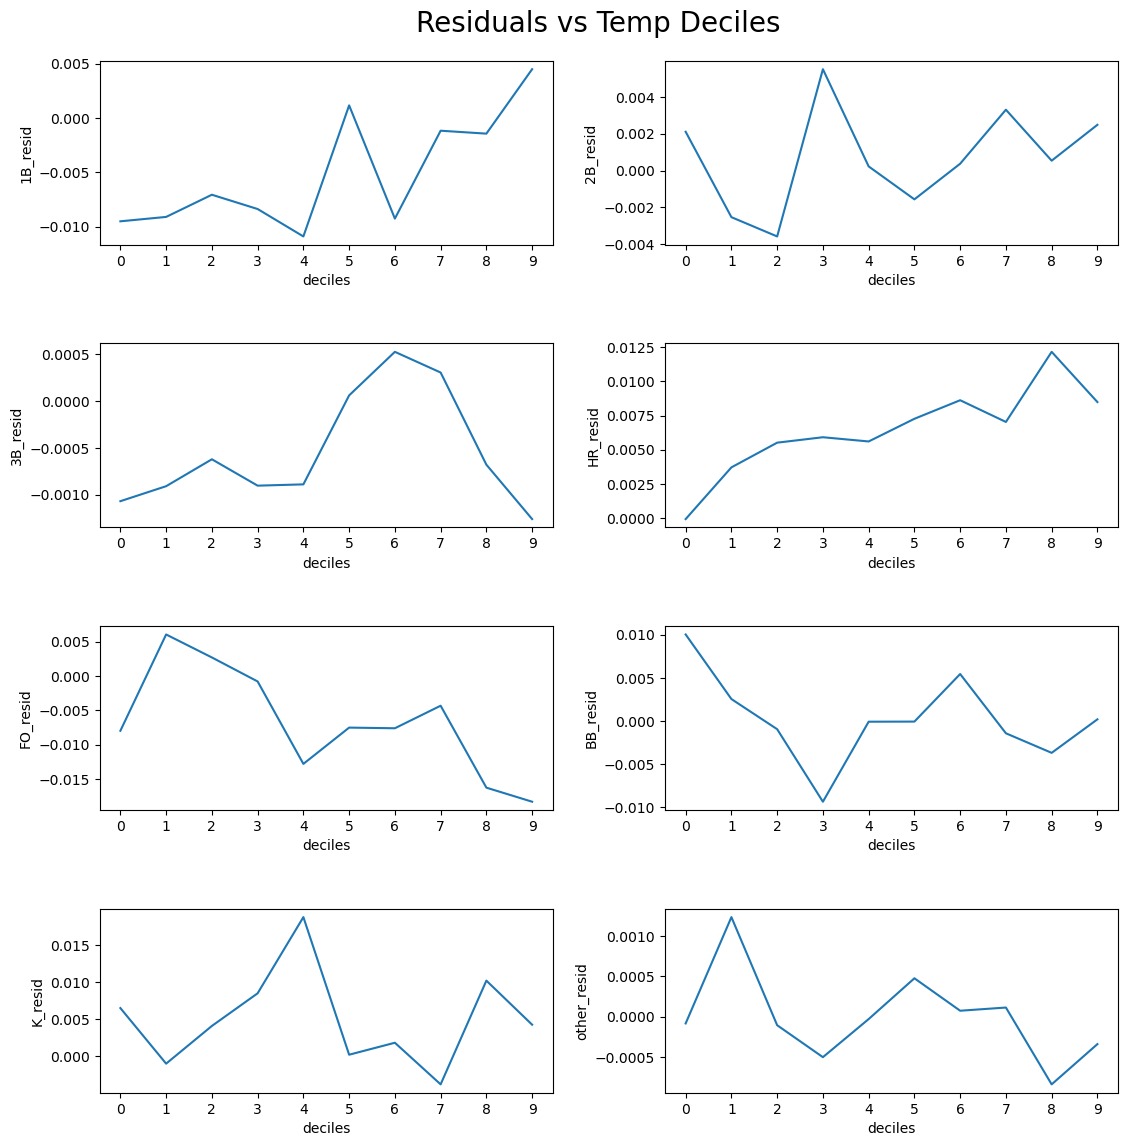

In [11]:
fig, axes = plt.subplots(4, 2, figsize=[12, 12])
plt.tight_layout(pad=5)

for col, ax in zip(main.RESID_COL, axes.ravel()):
    sns.lineplot(data=resid_decile_temp, x='deciles', y=col, ax=ax)
    ax.set_xticks(range(10))
fig.suptitle('Residuals vs Temp Deciles', fontsize=20)
plt.show()

# Speed

In [12]:
resid_decile_speed = pa_df.groupby(pd.qcut(pa_df['sprint_speed'], 10)).agg({
    '1B_resid':'mean',
    '2B_resid':'mean',
    '3B_resid':'mean',
    'HR_resid':'mean',
    'FO_resid':'mean',
    'K_resid':'mean',
    'BB_resid':'mean',
    'other_resid':'mean',
}).reset_index().copy()
resid_decile_speed['deciles'] = resid_decile_speed.groupby(['sprint_speed']).ngroup()

resid_decile_speed

,sprint_speed,1B_resid,2B_resid,3B_resid,HR_resid,FO_resid,K_resid,BB_resid,other_resid,deciles
0,"(22.099, 25.2]",-0.007864,-0.001486,-0.001593,0.002650,-0.003549,0.003829,0.007799,0.000214,0
1,"(25.2, 25.7]",-0.006432,-0.001651,-0.001421,0.003697,0.000532,0.007155,-0.001304,-0.000576,1
2,"(25.7, 26.2]",-0.000300,-0.004176,-0.000809,0.002367,-0.007489,0.014876,-0.004172,-0.000298,2
3,"(26.2, 26.6]",-0.005007,-0.001710,-0.000199,0.006519,-0.003409,0.000139,0.002680,0.000988,3
4,"(26.6, 26.9]",-0.006029,0.003432,-0.000619,0.009962,0.001033,-0.003309,-0.004244,-0.000226,4
5,"(26.9, 27.5]",-0.015591,0.003324,-0.000443,0.009295,-0.002528,0.004540,0.001809,-0.000407,5
6,"(27.5, 27.9]",-0.005259,-0.000720,-0.000155,0.012662,-0.017236,0.009171,0.001843,-0.000306,6
7,"(27.9, 28.2]",-0.003881,0.005088,0.000196,0.004704,-0.000181,-0.005018,-0.001032,0.000126,7
8,"(28.2, 28.8]",0.001174,0.004819,-0.000109,0.007641,-0.013941,0.002091,-0.001146,-0.000529,8
9,"(28.8, 30.4]",-0.003721,-0.000281,0.000022,0.001964,-0.015433,0.016027,0.000087,0.001336,9


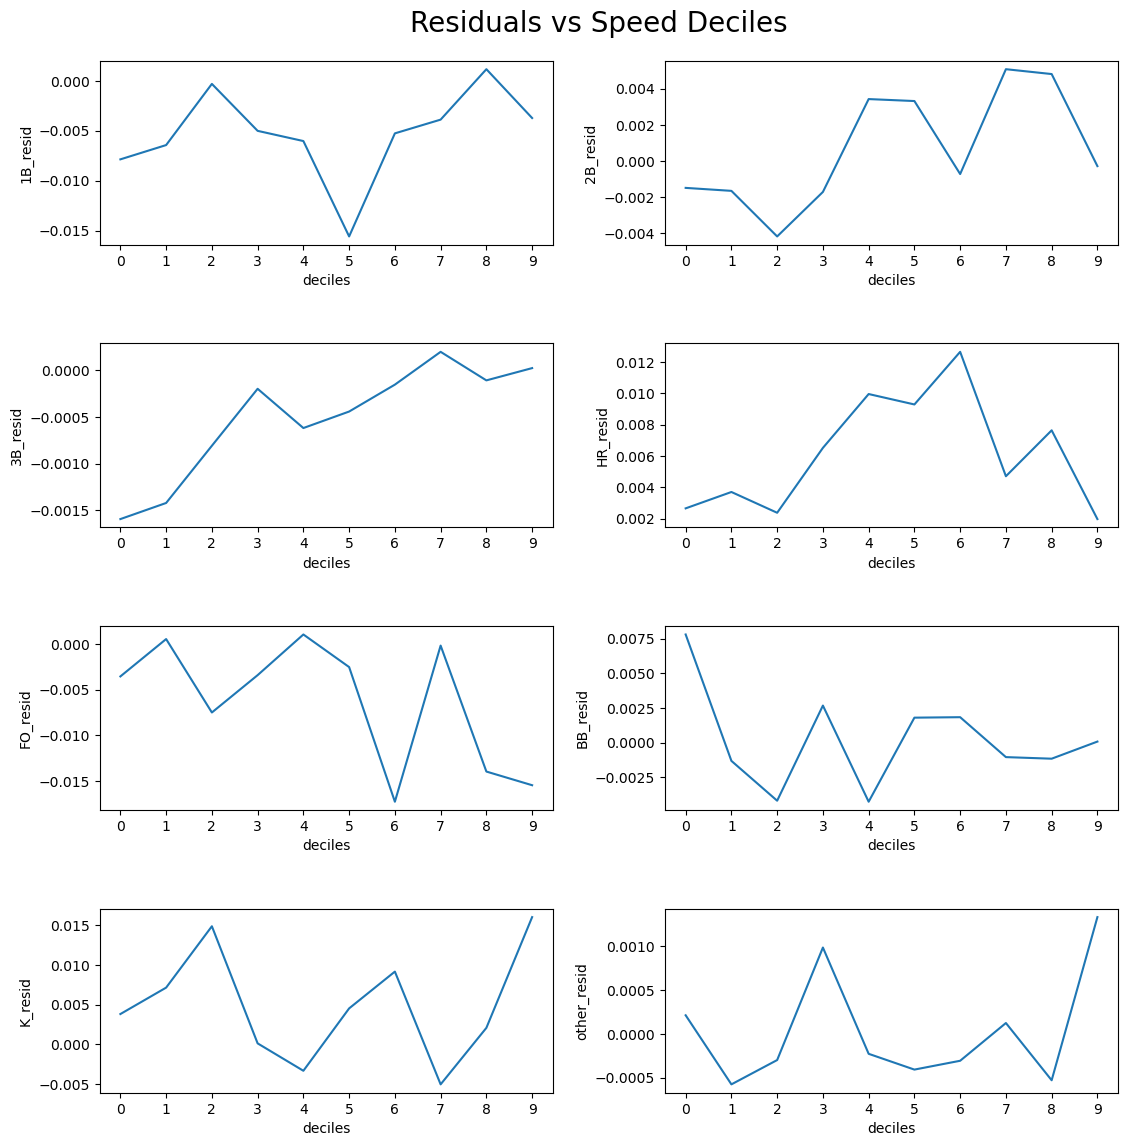

In [13]:
fig, axes = plt.subplots(4, 2, figsize=[12, 12])
plt.tight_layout(pad=5)

for col, ax in zip(main.RESID_COL, axes.ravel()):
    sns.lineplot(data=resid_decile_speed, x='deciles', y=col, ax=ax)
    ax.set_xticks(range(10))
fig.suptitle('Residuals vs Speed Deciles', fontsize=20)
plt.show()

# Platoon

In [14]:
resid_platoon = pa_df.groupby('platoon').agg({
    '1B_resid':'mean',
    '2B_resid':'mean',
    '3B_resid':'mean',
    'HR_resid':'mean',
    'FO_resid':'mean',
    'K_resid':'mean',
    'BB_resid':'mean',
    'other_resid':'mean',
}).reset_index().copy()

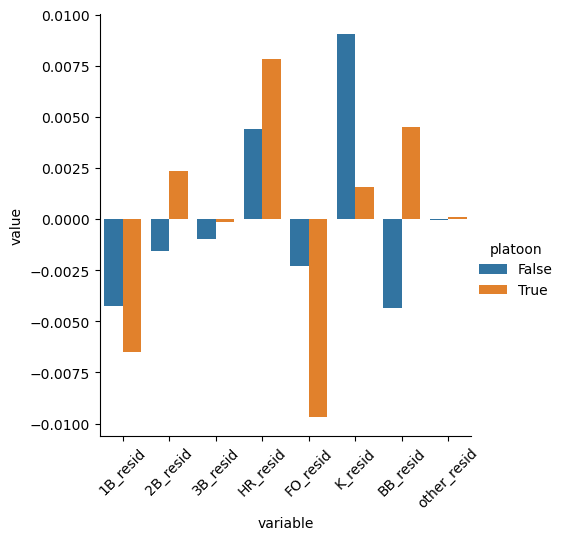

In [15]:
resid_platoon_melt = pd.melt(resid_platoon, id_vars = "platoon")
sns.catplot(x = 'variable', y='value', 
            hue = 'platoon',data=resid_platoon_melt, 
            kind='bar')
plt.xticks(rotation=45)
plt.show()

# Park Factors

In [113]:
all_matchUp_df = pd.read_csv('data/all_matchUp_df.csv', index_col=[0])

In [114]:
pk_df = pd.read_csv('data/ParkFactors_15-22.csv', index_col=[0])

In [115]:
pk_df.rename(columns={'SO':'K'}, inplace=True)

In [116]:
pk_df.head()

,Rk.,Team,Team_Abb,Venue,Year,Park Factor,wOBACon,xwOBACon,BACON,xBACON,HardHit,R,OBP,H,1B,2B,3B,HR,BB,K,PA
0,1,Rockies,COL,Coors Field,2015,118,117,104,116,104,107,139,116,123,124,117,190,119,99,84,6092
1,2,Guardians,CLE,Progressive Field,2015,110,111,107,113,107,105,121,111,113,110,140,74,94,106,98,6033
2,3,Red Sox,BOS,Fenway Park,2015,107,109,101,109,101,103,114,106,110,107,125,101,101,92,98,6174
3,4,Rangers,TEX,Globe Life Park in Arlington,2015,106,104,105,105,104,102,112,107,107,109,110,90,99,111,90,6594
4,5,Orioles,BAL,Oriole Park at Camden Yards,2015,105,105,102,103,101,100,110,103,107,107,93,62,136,91,94,5990


# Calculate Residuals

In [117]:
all_matchUp_df.head()

,game_year,game_pk,at_bat_number,pitcher,batter,home_team,event_type,des,1B,2B,3B,BB,FO,HR,K,other,1B_proba,2B_proba,3B_proba,HR_proba,FO_proba,BB_proba,K_proba,other_proba
0,2015,413649,1,433587,594777,SEA,K,Kole Calhoun called out on strikes.,0,0,0,0,0,0,1,0,0.135260,0.042021,0.003346,0.036416,0.461470,0.098783,0.219501,0.003203
1,2015,413649,2,433587,545361,SEA,HR,Mike Trout homers (1) on a fly ball to center ...,0,0,0,0,0,1,0,0,0.135075,0.046411,0.005117,0.051822,0.411027,0.136238,0.212590,0.001722
2,2015,413649,3,433587,405395,SEA,K,Albert Pujols strikes out on a foul tip.,0,0,0,0,0,0,1,0,0.144617,0.038200,0.001425,0.043213,0.529832,0.082308,0.158359,0.002045
3,2015,413649,4,433587,459964,SEA,K,Matt Joyce strikes out swinging.,0,0,0,0,0,0,1,0,0.126675,0.043944,0.002156,0.034679,0.454561,0.123917,0.212173,0.001895
4,2015,413649,5,450308,457706,SEA,FO,"Austin Jackson grounds out, shortstop Erick Ay...",0,0,0,0,1,0,0,0,0.166731,0.051894,0.005141,0.028331,0.473612,0.074692,0.198115,0.001483


In [118]:
event_list = ['1B', '2B', '3B', 'HR', 'FO', 'BB', 'K', 'other']
event_proba_list = ['1B_proba', '2B_proba', '3B_proba', 'HR_proba', 'FO_proba', 'BB_proba', 'K_proba', 'other_proba']

for event in list(zip(event_list, event_proba_list)):
    all_matchUp_df[event[0] + '_resid'] = all_matchUp_df[event[0]] - all_matchUp_df[event[1]]

# Merge all_matchUp_df with pk_df

In [119]:
pk_df.head()

,Rk.,Team,Team_Abb,Venue,Year,Park Factor,wOBACon,xwOBACon,BACON,xBACON,HardHit,R,OBP,H,1B,2B,3B,HR,BB,K,PA
0,1,Rockies,COL,Coors Field,2015,118,117,104,116,104,107,139,116,123,124,117,190,119,99,84,6092
1,2,Guardians,CLE,Progressive Field,2015,110,111,107,113,107,105,121,111,113,110,140,74,94,106,98,6033
2,3,Red Sox,BOS,Fenway Park,2015,107,109,101,109,101,103,114,106,110,107,125,101,101,92,98,6174
3,4,Rangers,TEX,Globe Life Park in Arlington,2015,106,104,105,105,104,102,112,107,107,109,110,90,99,111,90,6594
4,5,Orioles,BAL,Oriole Park at Camden Yards,2015,105,105,102,103,101,100,110,103,107,107,93,62,136,91,94,5990


In [120]:
all_matchUp_df.head()

,game_year,game_pk,at_bat_number,pitcher,batter,home_team,event_type,des,1B,2B,3B,BB,FO,HR,K,other,1B_proba,2B_proba,3B_proba,HR_proba,FO_proba,BB_proba,K_proba,other_proba,1B_resid,2B_resid,3B_resid,HR_resid,FO_resid,BB_resid,K_resid,other_resid
0,2015,413649,1,433587,594777,SEA,K,Kole Calhoun called out on strikes.,0,0,0,0,0,0,1,0,0.135260,0.042021,0.003346,0.036416,0.461470,0.098783,0.219501,0.003203,-0.135260,-0.042021,-0.003346,-0.036416,-0.461470,-0.098783,0.780499,-0.003203
1,2015,413649,2,433587,545361,SEA,HR,Mike Trout homers (1) on a fly ball to center ...,0,0,0,0,0,1,0,0,0.135075,0.046411,0.005117,0.051822,0.411027,0.136238,0.212590,0.001722,-0.135075,-0.046411,-0.005117,0.948178,-0.411027,-0.136238,-0.212590,-0.001722
2,2015,413649,3,433587,405395,SEA,K,Albert Pujols strikes out on a foul tip.,0,0,0,0,0,0,1,0,0.144617,0.038200,0.001425,0.043213,0.529832,0.082308,0.158359,0.002045,-0.144617,-0.038200,-0.001425,-0.043213,-0.529832,-0.082308,0.841641,-0.002045
3,2015,413649,4,433587,459964,SEA,K,Matt Joyce strikes out swinging.,0,0,0,0,0,0,1,0,0.126675,0.043944,0.002156,0.034679,0.454561,0.123917,0.212173,0.001895,-0.126675,-0.043944,-0.002156,-0.034679,-0.454561,-0.123917,0.787827,-0.001895
4,2015,413649,5,450308,457706,SEA,FO,"Austin Jackson grounds out, shortstop Erick Ay...",0,0,0,0,1,0,0,0,0.166731,0.051894,0.005141,0.028331,0.473612,0.074692,0.198115,0.001483,-0.166731,-0.051894,-0.005141,-0.028331,0.526388,-0.074692,-0.198115,-0.001483


In [121]:
pk_col = pk_df.columns[1:]
all_matchUp_df = all_matchUp_df.merge(pk_df[pk_col], left_on=['home_team', 'game_year'], right_on=['Team_Abb', 'Year'], how='left', suffixes=('', '_pf'))

In [122]:
# scale down park factors by 100:
all_matchUp_df[all_matchUp_df.columns[-16:-1]] = all_matchUp_df[all_matchUp_df.columns[-16:-1]]/100

In [123]:
all_matchUp_df.rename(columns={'Park Factor':'park_factor'}, inplace=True)

In [124]:
all_matchUp_df.head()

,game_year,game_pk,at_bat_number,pitcher,batter,home_team,event_type,des,1B,2B,3B,BB,FO,HR,K,other,1B_proba,2B_proba,3B_proba,HR_proba,FO_proba,BB_proba,K_proba,other_proba,1B_resid,2B_resid,3B_resid,HR_resid,FO_resid,BB_resid,K_resid,other_resid,Team,Team_Abb,Venue,Year,park_factor,wOBACon,xwOBACon,BACON,xBACON,HardHit,R,OBP,H,1B_pf,2B_pf,3B_pf,HR_pf,BB_pf,K_pf,PA
0,2015,413649,1,433587,594777,SEA,K,Kole Calhoun called out on strikes.,0,0,0,0,0,0,1,0,0.135260,0.042021,0.003346,0.036416,0.461470,0.098783,0.219501,0.003203,-0.135260,-0.042021,-0.003346,-0.036416,-0.461470,-0.098783,0.780499,-0.003203,Mariners,SEA,T-Mobile Park,2015,0.96,0.97,0.99,0.98,0.99,0.94,0.92,0.97,0.95,0.99,0.86,0.74,0.91,1.01,1.09,6292
1,2015,413649,2,433587,545361,SEA,HR,Mike Trout homers (1) on a fly ball to center ...,0,0,0,0,0,1,0,0,0.135075,0.046411,0.005117,0.051822,0.411027,0.136238,0.212590,0.001722,-0.135075,-0.046411,-0.005117,0.948178,-0.411027,-0.136238,-0.212590,-0.001722,Mariners,SEA,T-Mobile Park,2015,0.96,0.97,0.99,0.98,0.99,0.94,0.92,0.97,0.95,0.99,0.86,0.74,0.91,1.01,1.09,6292
2,2015,413649,3,433587,405395,SEA,K,Albert Pujols strikes out on a foul tip.,0,0,0,0,0,0,1,0,0.144617,0.038200,0.001425,0.043213,0.529832,0.082308,0.158359,0.002045,-0.144617,-0.038200,-0.001425,-0.043213,-0.529832,-0.082308,0.841641,-0.002045,Mariners,SEA,T-Mobile Park,2015,0.96,0.97,0.99,0.98,0.99,0.94,0.92,0.97,0.95,0.99,0.86,0.74,0.91,1.01,1.09,6292
3,2015,413649,4,433587,459964,SEA,K,Matt Joyce strikes out swinging.,0,0,0,0,0,0,1,0,0.126675,0.043944,0.002156,0.034679,0.454561,0.123917,0.212173,0.001895,-0.126675,-0.043944,-0.002156,-0.034679,-0.454561,-0.123917,0.787827,-0.001895,Mariners,SEA,T-Mobile Park,2015,0.96,0.97,0.99,0.98,0.99,0.94,0.92,0.97,0.95,0.99,0.86,0.74,0.91,1.01,1.09,6292
4,2015,413649,5,450308,457706,SEA,FO,"Austin Jackson grounds out, shortstop Erick Ay...",0,0,0,0,1,0,0,0,0.166731,0.051894,0.005141,0.028331,0.473612,0.074692,0.198115,0.001483,-0.166731,-0.051894,-0.005141,-0.028331,0.526388,-0.074692,-0.198115,-0.001483,Mariners,SEA,T-Mobile Park,2015,0.96,0.97,0.99,0.98,0.99,0.94,0.92,0.97,0.95,0.99,0.86,0.74,0.91,1.01,1.09,6292


# Examine individual events:
## 1B

In [125]:
resid_decile_1B = all_matchUp_df.groupby(pd.qcut(all_matchUp_df['1B_pf'], 10)).agg({'1B_resid':'mean'}).reset_index().copy()
resid_decile_1B['deciles'] = resid_decile_1B.groupby(['1B_pf']).ngroup()
resid_decile_1B

,1B_pf,1B_resid,deciles
0,"(0.869, 0.93]",-0.006461,0
1,"(0.93, 0.94]",-0.005973,1
2,"(0.94, 0.96]",-0.005227,2
3,"(0.96, 0.98]",-0.001270,3
4,"(0.98, 0.99]",-0.000635,4
5,"(0.99, 1.01]",0.002173,5
6,"(1.01, 1.03]",0.002498,6
7,"(1.03, 1.06]",0.003663,7
8,"(1.06, 1.08]",0.009463,8
9,"(1.08, 1.24]",0.011831,9


## 2B

In [126]:
resid_decile_2B = all_matchUp_df.groupby(pd.qcut(all_matchUp_df['2B_pf'], 10)).agg({'2B_resid':'mean'}).reset_index().copy()
resid_decile_2B['deciles'] = resid_decile_2B.groupby(['2B_pf']).ngroup()
resid_decile_2B

,2B_pf,2B_resid,deciles
0,"(0.689, 0.86]",-0.004665,0
1,"(0.86, 0.88]",-0.003811,1
2,"(0.88, 0.92]",-0.003277,2
3,"(0.92, 0.95]",-0.001459,3
4,"(0.95, 0.99]",-0.001042,4
5,"(0.99, 1.02]",0.001016,5
6,"(1.02, 1.07]",0.001592,6
7,"(1.07, 1.11]",0.003462,7
8,"(1.11, 1.19]",0.004151,8
9,"(1.19, 1.43]",0.009574,9


## 3B

In [127]:
resid_decile_3B = all_matchUp_df.groupby(pd.qcut(all_matchUp_df['3B_pf'], 10)).agg({'3B_resid':'mean'}).reset_index().copy()
resid_decile_3B['deciles'] = resid_decile_3B.groupby(['3B_pf']).ngroup()
resid_decile_3B

,3B_pf,3B_resid,deciles
0,"(0.299, 0.55]",-0.001988,0
1,"(0.55, 0.68]",-0.001139,1
2,"(0.68, 0.74]",-0.000859,2
3,"(0.74, 0.85]",-0.000535,3
4,"(0.85, 0.95]",-0.000362,4
5,"(0.95, 1.05]",-0.000031,5
6,"(1.05, 1.18]",0.000184,6
7,"(1.18, 1.36]",0.001241,7
8,"(1.36, 1.65]",0.001369,8
9,"(1.65, 2.88]",0.002538,9


## HR

In [128]:
resid_decile_HR = all_matchUp_df.groupby(pd.qcut(all_matchUp_df['HR_pf'], 10)).agg({'HR_resid':'mean'}).reset_index().copy()
resid_decile_HR['deciles'] = resid_decile_HR.groupby(['HR_pf']).ngroup()
resid_decile_HR

,HR_pf,HR_resid,deciles
0,"(0.599, 0.79]",-0.006394,0
1,"(0.79, 0.85]",-0.004387,1
2,"(0.85, 0.9]",-0.000474,2
3,"(0.9, 0.95]",-0.000703,3
4,"(0.95, 0.99]",-0.000583,4
5,"(0.99, 1.05]",0.000746,5
6,"(1.05, 1.1]",0.001819,6
7,"(1.1, 1.16]",0.003987,7
8,"(1.16, 1.23]",0.004671,8
9,"(1.23, 1.77]",0.006050,9


## BB

In [129]:
resid_decile_BB = all_matchUp_df.groupby(pd.qcut(all_matchUp_df['BB_pf'], 10)).agg({'BB_resid':'mean'}).reset_index().copy()
resid_decile_BB['deciles'] = resid_decile_BB.groupby(['BB_pf']).ngroup()
resid_decile_BB

,BB_pf,BB_resid,deciles
0,"(0.789, 0.91]",-0.005608,0
1,"(0.91, 0.94]",-0.004576,1
2,"(0.94, 0.96]",-0.004534,2
3,"(0.96, 0.98]",-0.000255,3
4,"(0.98, 1.0]",0.000029,4
5,"(1.0, 1.02]",-0.000638,5
6,"(1.02, 1.04]",0.002015,6
7,"(1.04, 1.06]",0.000963,7
8,"(1.06, 1.08]",0.006115,8
9,"(1.08, 1.22]",0.004808,9


## K

In [130]:
resid_decile_K = all_matchUp_df.groupby(pd.qcut(all_matchUp_df['K_pf'], 10)).agg({'K_resid':'mean'}).reset_index().copy()
resid_decile_K['deciles'] = resid_decile_K.groupby(['K_pf']).ngroup()
resid_decile_K

,K_pf,K_resid,deciles
0,"(0.839, 0.91]",-0.021693,0
1,"(0.91, 0.94]",-0.014319,1
2,"(0.94, 0.96]",-0.009010,2
3,"(0.96, 0.98]",-0.002253,3
4,"(0.98, 1.0]",-0.002410,4
5,"(1.0, 1.02]",0.001879,5
6,"(1.02, 1.04]",0.006787,6
7,"(1.04, 1.06]",0.010967,7
8,"(1.06, 1.09]",0.010952,8
9,"(1.09, 1.16]",0.015722,9


# Adjust P based on park factors

In [131]:
all_matchUp_df.head()

,game_year,game_pk,at_bat_number,pitcher,batter,home_team,event_type,des,1B,2B,3B,BB,FO,HR,K,other,1B_proba,2B_proba,3B_proba,HR_proba,FO_proba,BB_proba,K_proba,other_proba,1B_resid,2B_resid,3B_resid,HR_resid,FO_resid,BB_resid,K_resid,other_resid,Team,Team_Abb,Venue,Year,park_factor,wOBACon,xwOBACon,BACON,xBACON,HardHit,R,OBP,H,1B_pf,2B_pf,3B_pf,HR_pf,BB_pf,K_pf,PA
0,2015,413649,1,433587,594777,SEA,K,Kole Calhoun called out on strikes.,0,0,0,0,0,0,1,0,0.135260,0.042021,0.003346,0.036416,0.461470,0.098783,0.219501,0.003203,-0.135260,-0.042021,-0.003346,-0.036416,-0.461470,-0.098783,0.780499,-0.003203,Mariners,SEA,T-Mobile Park,2015,0.96,0.97,0.99,0.98,0.99,0.94,0.92,0.97,0.95,0.99,0.86,0.74,0.91,1.01,1.09,6292
1,2015,413649,2,433587,545361,SEA,HR,Mike Trout homers (1) on a fly ball to center ...,0,0,0,0,0,1,0,0,0.135075,0.046411,0.005117,0.051822,0.411027,0.136238,0.212590,0.001722,-0.135075,-0.046411,-0.005117,0.948178,-0.411027,-0.136238,-0.212590,-0.001722,Mariners,SEA,T-Mobile Park,2015,0.96,0.97,0.99,0.98,0.99,0.94,0.92,0.97,0.95,0.99,0.86,0.74,0.91,1.01,1.09,6292
2,2015,413649,3,433587,405395,SEA,K,Albert Pujols strikes out on a foul tip.,0,0,0,0,0,0,1,0,0.144617,0.038200,0.001425,0.043213,0.529832,0.082308,0.158359,0.002045,-0.144617,-0.038200,-0.001425,-0.043213,-0.529832,-0.082308,0.841641,-0.002045,Mariners,SEA,T-Mobile Park,2015,0.96,0.97,0.99,0.98,0.99,0.94,0.92,0.97,0.95,0.99,0.86,0.74,0.91,1.01,1.09,6292
3,2015,413649,4,433587,459964,SEA,K,Matt Joyce strikes out swinging.,0,0,0,0,0,0,1,0,0.126675,0.043944,0.002156,0.034679,0.454561,0.123917,0.212173,0.001895,-0.126675,-0.043944,-0.002156,-0.034679,-0.454561,-0.123917,0.787827,-0.001895,Mariners,SEA,T-Mobile Park,2015,0.96,0.97,0.99,0.98,0.99,0.94,0.92,0.97,0.95,0.99,0.86,0.74,0.91,1.01,1.09,6292
4,2015,413649,5,450308,457706,SEA,FO,"Austin Jackson grounds out, shortstop Erick Ay...",0,0,0,0,1,0,0,0,0.166731,0.051894,0.005141,0.028331,0.473612,0.074692,0.198115,0.001483,-0.166731,-0.051894,-0.005141,-0.028331,0.526388,-0.074692,-0.198115,-0.001483,Mariners,SEA,T-Mobile Park,2015,0.96,0.97,0.99,0.98,0.99,0.94,0.92,0.97,0.95,0.99,0.86,0.74,0.91,1.01,1.09,6292


In [132]:
all_matchUp_df['1B_proba_adj'] = all_matchUp_df['1B_proba'] * all_matchUp_df['1B_pf']
all_matchUp_df['2B_proba_adj'] = all_matchUp_df['2B_proba'] * all_matchUp_df['2B_pf']
all_matchUp_df['3B_proba_adj'] = all_matchUp_df['3B_proba'] * all_matchUp_df['3B_pf']
all_matchUp_df['HR_proba_adj'] = all_matchUp_df['HR_proba'] * all_matchUp_df['HR_pf']
all_matchUp_df['FO_proba_adj'] = all_matchUp_df['FO_proba']
all_matchUp_df['BB_proba_adj'] = all_matchUp_df['BB_proba'] * all_matchUp_df['BB_pf']
all_matchUp_df['K_proba_adj'] = all_matchUp_df['K_proba'] * all_matchUp_df['K_pf']
all_matchUp_df['other_proba_adj'] = all_matchUp_df['other_proba']

In [133]:
proba_adj_col = ['1B_proba_adj', '2B_proba_adj', '3B_proba_adj', 'HR_proba_adj', 'FO_proba_adj', 'BB_proba_adj', 'K_proba_adj', 'other_proba_adj']

In [134]:
devider = all_matchUp_df[proba_adj_col].sum(axis=1)

In [135]:
for p in proba_adj_col:
    all_matchUp_df[p] = all_matchUp_df[p] / devider

In [136]:
event_list

['1B', '2B', '3B', 'HR', 'FO', 'BB', 'K', 'other']

In [137]:
utils.get_brier_score(all_matchUp_df[event_list].values, all_matchUp_df[proba_adj_col])

0.6964112656663454

In [138]:
all_matchUp_df.head()

,game_year,game_pk,at_bat_number,pitcher,batter,home_team,event_type,des,1B,2B,3B,BB,FO,HR,K,other,1B_proba,2B_proba,3B_proba,HR_proba,FO_proba,BB_proba,K_proba,other_proba,1B_resid,2B_resid,3B_resid,HR_resid,FO_resid,BB_resid,K_resid,other_resid,Team,Team_Abb,Venue,Year,park_factor,wOBACon,xwOBACon,BACON,xBACON,HardHit,R,OBP,H,1B_pf,2B_pf,3B_pf,HR_pf,BB_pf,K_pf,PA,1B_proba_adj,2B_proba_adj,3B_proba_adj,HR_proba_adj,FO_proba_adj,BB_proba_adj,K_proba_adj,other_proba_adj
0,2015,413649,1,433587,594777,SEA,K,Kole Calhoun called out on strikes.,0,0,0,0,0,0,1,0,0.135260,0.042021,0.003346,0.036416,0.461470,0.098783,0.219501,0.003203,-0.135260,-0.042021,-0.003346,-0.036416,-0.461470,-0.098783,0.780499,-0.003203,Mariners,SEA,T-Mobile Park,2015,0.96,0.97,0.99,0.98,0.99,0.94,0.92,0.97,0.95,0.99,0.86,0.74,0.91,1.01,1.09,6292,0.132665,0.035803,0.002453,0.032832,0.457191,0.098846,0.237037,0.003173
1,2015,413649,2,433587,545361,SEA,HR,Mike Trout homers (1) on a fly ball to center ...,0,0,0,0,0,1,0,0,0.135075,0.046411,0.005117,0.051822,0.411027,0.136238,0.212590,0.001722,-0.135075,-0.046411,-0.005117,0.948178,-0.411027,-0.136238,-0.212590,-0.001722,Mariners,SEA,T-Mobile Park,2015,0.96,0.97,0.99,0.98,0.99,0.94,0.92,0.97,0.95,0.99,0.86,0.74,0.91,1.01,1.09,6292,0.132840,0.039649,0.003761,0.046846,0.408311,0.136691,0.230191,0.001710
2,2015,413649,3,433587,405395,SEA,K,Albert Pujols strikes out on a foul tip.,0,0,0,0,0,0,1,0,0.144617,0.038200,0.001425,0.043213,0.529832,0.082308,0.158359,0.002045,-0.144617,-0.038200,-0.001425,-0.043213,-0.529832,-0.082308,0.841641,-0.002045,Mariners,SEA,T-Mobile Park,2015,0.96,0.97,0.99,0.98,0.99,0.94,0.92,0.97,0.95,0.99,0.86,0.74,0.91,1.01,1.09,6292,0.142598,0.032720,0.001050,0.039167,0.527710,0.082798,0.171920,0.002037
3,2015,413649,4,433587,459964,SEA,K,Matt Joyce strikes out swinging.,0,0,0,0,0,0,1,0,0.126675,0.043944,0.002156,0.034679,0.454561,0.123917,0.212173,0.001895,-0.126675,-0.043944,-0.002156,-0.034679,-0.454561,-0.123917,0.787827,-0.001895,Mariners,SEA,T-Mobile Park,2015,0.96,0.97,0.99,0.98,0.99,0.94,0.92,0.97,0.95,0.99,0.86,0.74,0.91,1.01,1.09,6292,0.124260,0.037446,0.001581,0.031269,0.450402,0.124011,0.229152,0.001878
4,2015,413649,5,450308,457706,SEA,FO,"Austin Jackson grounds out, shortstop Erick Ay...",0,0,0,0,1,0,0,0,0.166731,0.051894,0.005141,0.028331,0.473612,0.074692,0.198115,0.001483,-0.166731,-0.051894,-0.005141,-0.028331,0.526388,-0.074692,-0.198115,-0.001483,Mariners,SEA,T-Mobile Park,2015,0.96,0.97,0.99,0.98,0.99,0.94,0.92,0.97,0.95,0.99,0.86,0.74,0.91,1.01,1.09,6292,0.164119,0.044373,0.003782,0.025634,0.470901,0.075007,0.214709,0.001474


In [151]:
# # read results from main.ipynb

results_sum_df = pd.read_csv('data/results_sum.csv', index_col=[0])

In [152]:
results_sum_df

,events,count_actual,count_pred,error_pct
0,1B,141446,140793.195694,0.004615
1,2B,44120,43835.461010,0.006449
2,3B,4221,4190.795388,0.007156
3,HR,31324,30998.230392,0.010400
4,FO,448923,448808.715820,0.000255
5,BB,86773,87333.731183,-0.006462
6,K,207438,208278.829645,-0.004053
7,other,2258,2264.040867,-0.002675


In [153]:
results_sum_df['pred_pf'] = all_matchUp_df[proba_adj_col].sum().values

In [154]:
results_sum_df['error_pct_pf'] = (results_sum_df['count_actual'] - results_sum_df['pred_pf'])/results_sum_df['count_actual']

In [155]:
results_sum_df

,events,count_actual,count_pred,error_pct,pred_pf,error_pct_pf
0,1B,141446,140793.195694,0.004615,140852.288150,0.004197
1,2B,44120,43835.461010,0.006449,44046.028773,0.001677
2,3B,4221,4190.795388,0.007156,4398.636049,-0.042084
3,HR,31324,30998.230392,0.010400,31182.761268,0.004509
4,FO,448923,448808.715820,0.000255,448418.821895,0.001123
5,BB,86773,87333.731183,-0.006462,87091.614330,-0.003672
6,K,207438,208278.829645,-0.004053,208251.105096,-0.003920
7,other,2258,2264.040867,-0.002675,2261.744439,-0.001658


In [156]:
results_sum_df['count_actual'].sum()

966503

In [157]:
results_sum_df['count_pred'].sum()

966502.9999999739

In [158]:
results_sum_df['pred_pf'].sum()

966503.0000000155

In [160]:
# all_matchUp_df.to_csv('data/all_matchUp_df.csv')